<a href="https://colab.research.google.com/github/ouardaoui/ML/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## worksapce ready 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("version:",tf.__version__)
print("version tf_hub",hub.__version__)

version: 2.4.1
version tf_hub 0.11.0


In [ ]:
#check label of our data 
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     80530662979f925e5854d840ac73418b  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


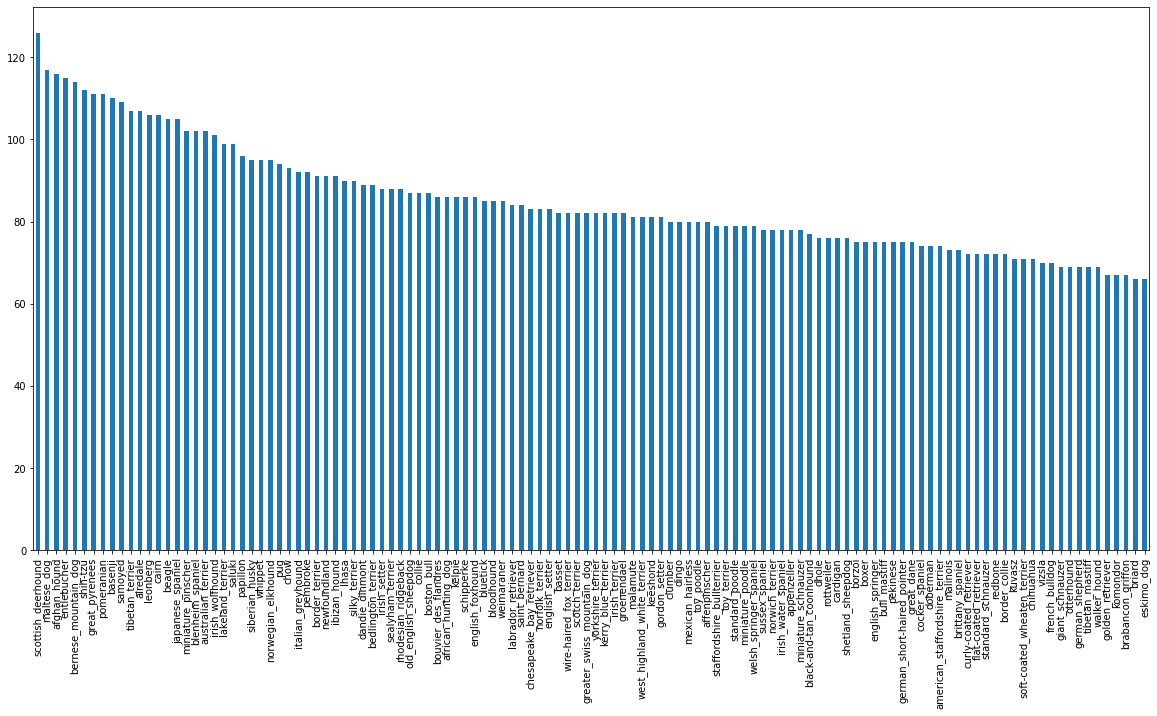

In [ ]:
#how many images are thre of each breed ?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

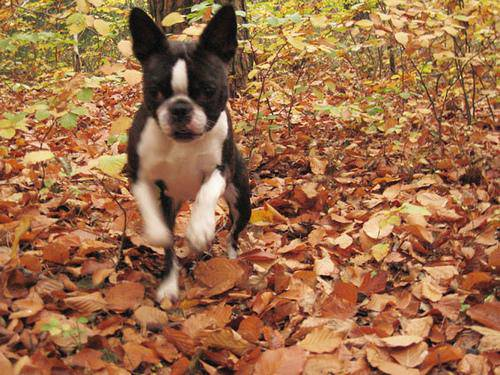

In [ ]:
# let's view an image 
from IPython.display import Image
Image("/content/drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(labels)#does same time above
len(labels)

10222

In [ ]:
#find the unique label value 
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
#turn a single value label into a array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
#turn every label  into a array of booleans
booleans_labels = [label == unique_breeds for label in labels]
booleans_labels[0:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
#turnning boolean array into integers
print(labels[0])#original labels 
print(np.where(unique_breeds == labels[0]))#index where label occurs 
print(booleans_labels[0].argmax())#index where label occurs in boolean array
print(booleans_labels[0].astype(int))#there will be 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### creating own  validation set
since data from kaggle doesn't come with validation set we 're go to create own.

In [ ]:
#setup X & y variables
filenames = ["/content/drive/MyDrive/dog-breed-identification/train/" + fname for fname in labels_csv["id"]+".jpg"]

X = filenames
y = booleans_labels
X[10]

'/content/drive/MyDrive/dog-breed-identification/train/004396df1acd0f1247b740ca2b14616e.jpg'

we 're giogng to start exprementation with 1000 images and increase as needed

In [ ]:
#set a number of image do you use for experementing
NUM_IMAGES = 2000 #@param {type:"slider",min:1000,max:10000,step:1000}

In [72]:
#split them into training and validation of total size NUM_IMAGES
from sklearn.model_selection import train_test_split
X_train ,X_val, y_train ,y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.20,random_state =42)
len(X_train),len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

##for processing images into to Tensors we 're write a fuction do a few things :
###1-take an image filepath as input
###2-use tensorflow  to read the file and save it to a variable
###3- turn our 'image' (a jpg) into the tensor of (224,244)
###4- normalize our image (cvt color channel value from 0-255 to 0-1 ) 
###5- resize the 'image' to be shape
###6- return the modified 'image

In [74]:
#convert image to NumPy array
from matplotlib.pyplot import imread  
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [75]:
image.max(),image.min()

(255, 0)

In [76]:
#turn image into Tensors
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [77]:
#difine image size
IMG_SIZE = 224
#create a functionfor preccesing image
def process_image(image_path, image_size=IMG_SIZE):
  #read a image file
  image = tf.io.read_file(image_path)
  #turn jpeg image into to tensers with 3 colours channels
  image = tf.io.decode_jpeg(image,channels=3)
  #cvt the colour channel value from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  #resize image to our desired value
  image = tf.image.resize(image , size=[IMG_SIZE,IMG_SIZE])
  return image

##Turning our data to return the batches size32

In [78]:
#create a simple function to return a tuple(image,label)
def get_image_label(image_path,label):
  image = process_image(image_path)
  return image,label

In [83]:
#demo of the above 
(process_image(X[42]),tf.constant(y[42])) 


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048